## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'AP'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-51.08530,0.087700,-7.730,978040.39,978036.665043,3.724957
1,-51.06630,0.077900,-4.940,978042.06,978038.083888,3.976112
2,-51.16970,0.228600,20.570,978040.94,978024.703537,16.236462
3,-51.18740,0.231800,-0.990,978036.48,978031.793204,4.686796
4,-51.20330,0.224000,-10.690,978038.54,978035.551732,2.988268
...,...,...,...,...,...,...
144,-50.94290,0.531464,-10.362,978036.66,978030.827720,5.832280
145,-50.92278,1.423701,2.842,978006.11,978003.514815,2.595185
146,-51.76787,3.536850,48.844,978025.53,978011.248036,14.281964
147,-51.63048,3.314728,18.522,978032.32,978018.688119,13.631881


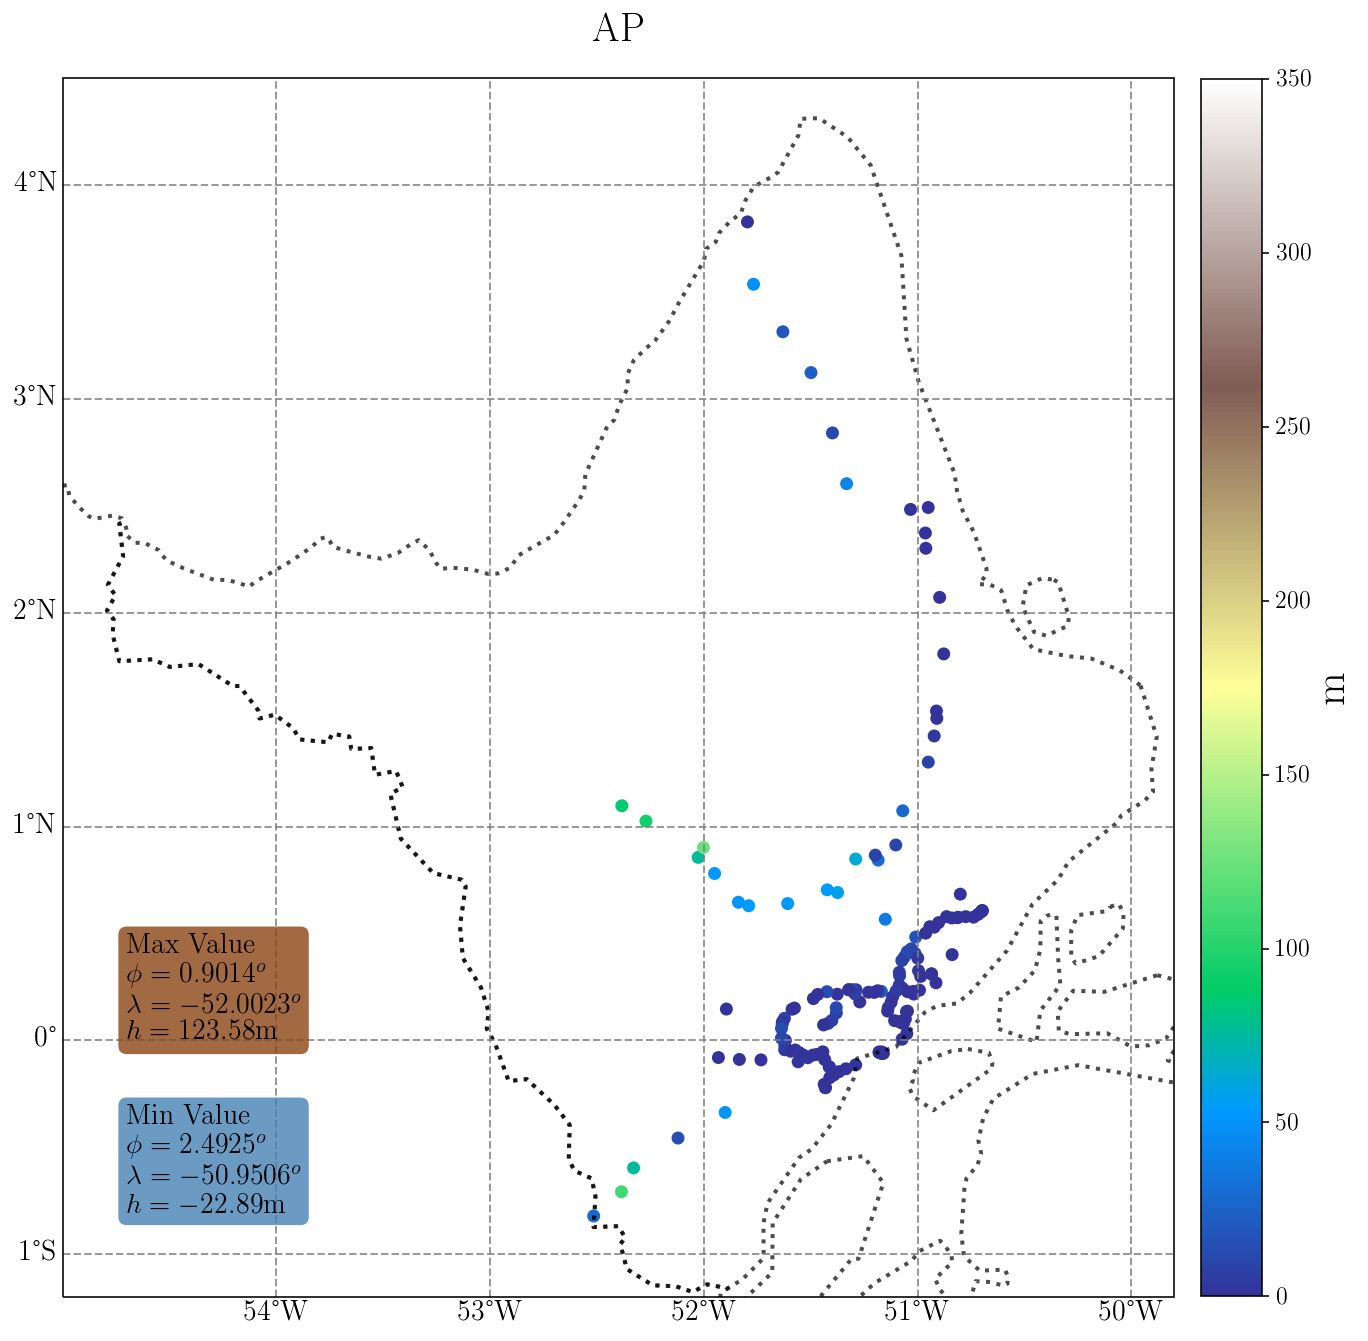

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(12.,14.), region=[-55,-49.8,-1.2,4.5], \
          sign=(-54.7,-54.7,0.,-0.8), cmap='terrain', shrink=0.8, lim_val=(True,True,0.,350.))

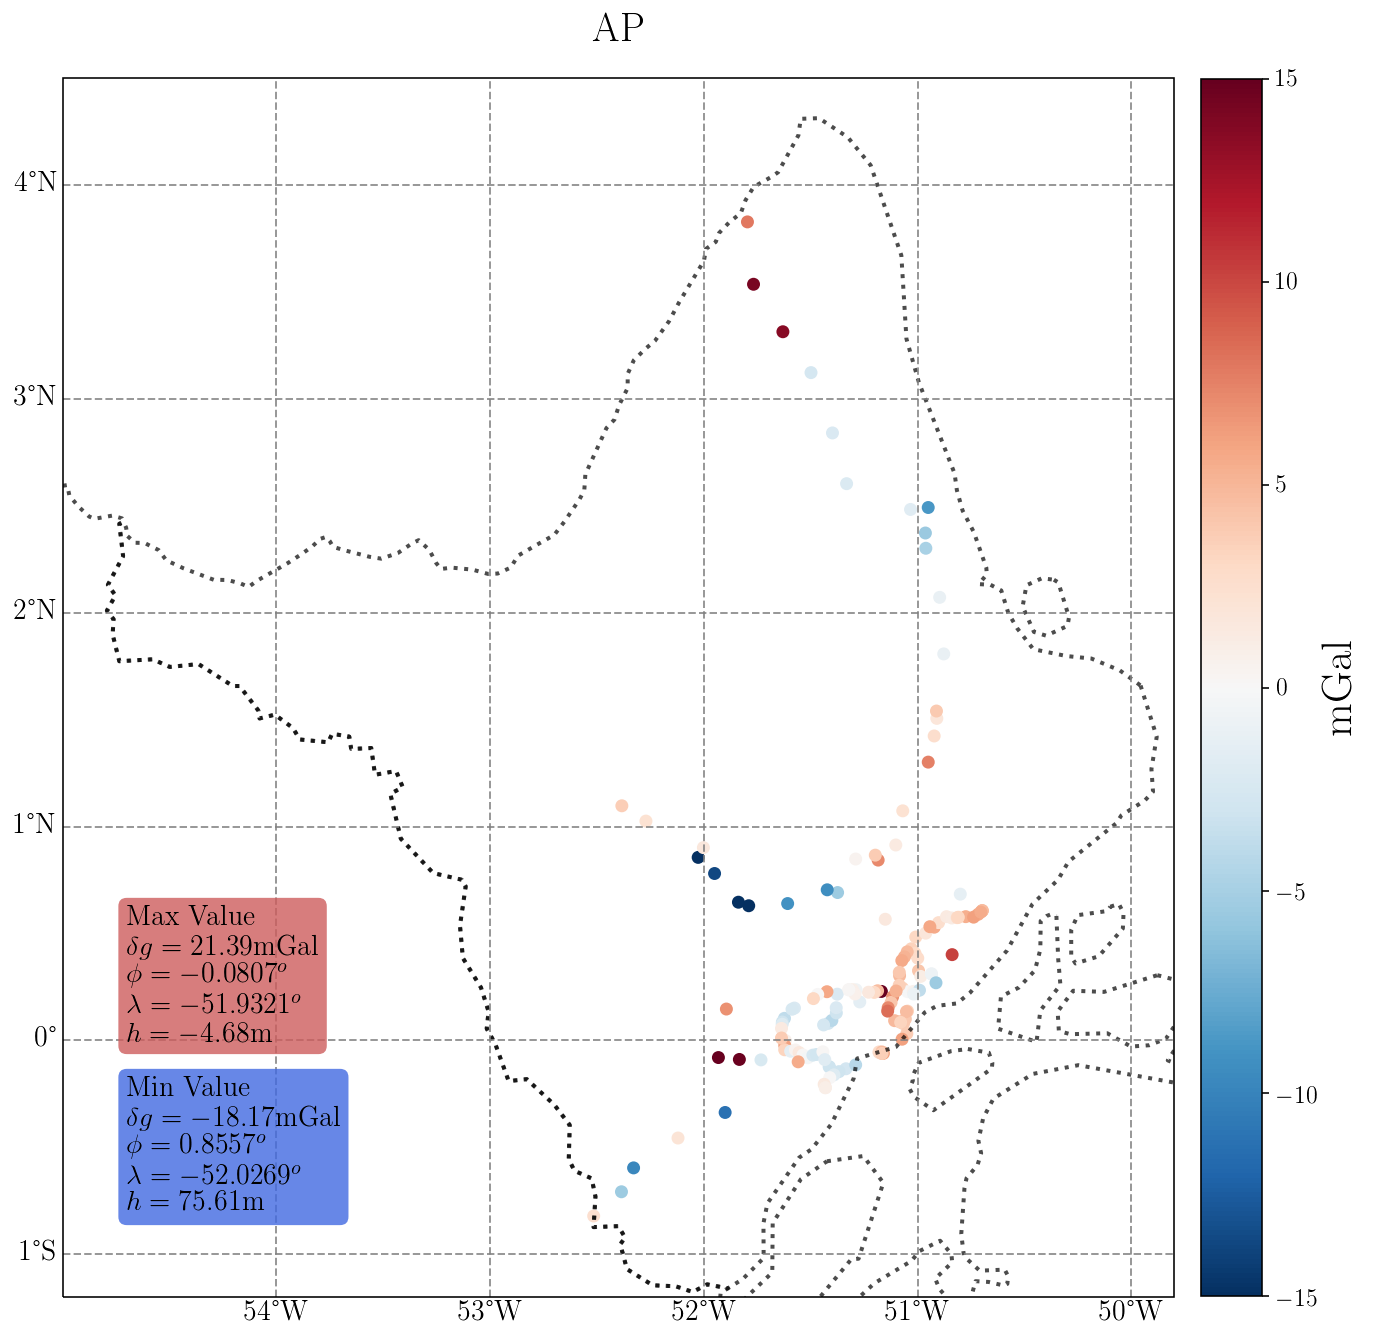

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-55,-49.8,-1.2,4.5], \
          sign=(-54.7,-54.7,0,-0.8), shrink=0.8, lim_val=(True, 15.))

In [8]:
index = np.argmax(df.ALT.values)
print('MAX', index, df.ALT[index], df.DIST[index])

index = np.argmin(df.ALT.values)
print('MIN', index, df.ALT[index], df.DIST[index])

MAX 137 123.58 1.6522943001473323
MIN 83 -22.89 -8.788253800012171


In [9]:
index = np.argmax(df.DIST.values)
print('MAX', index, df.ALT[index], df.DIST[index])

index = np.argmin(df.DIST.values)
print('MIN', index, df.ALT[index], df.DIST[index])

MAX 36 -4.68 21.393269899999723
MIN 129 75.60600000000001 -18.169258499867283


### Calculating rotation matrices and Cartesian coordinates

In [10]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
R = np.array(rotation_matrix(df.LONG, df.LAT))

## Estimating the first set of point-mass parameters

In [11]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [12]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [13]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]

In [14]:
Rcl = R[:, indl]

In [15]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(149, 149)


In [16]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [17]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

149


In [18]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [19]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

8.315137911552029e-09

In [20]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [21]:
rabs_max.append(rabs_max_l)

In [22]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

8.315137911552029e-09


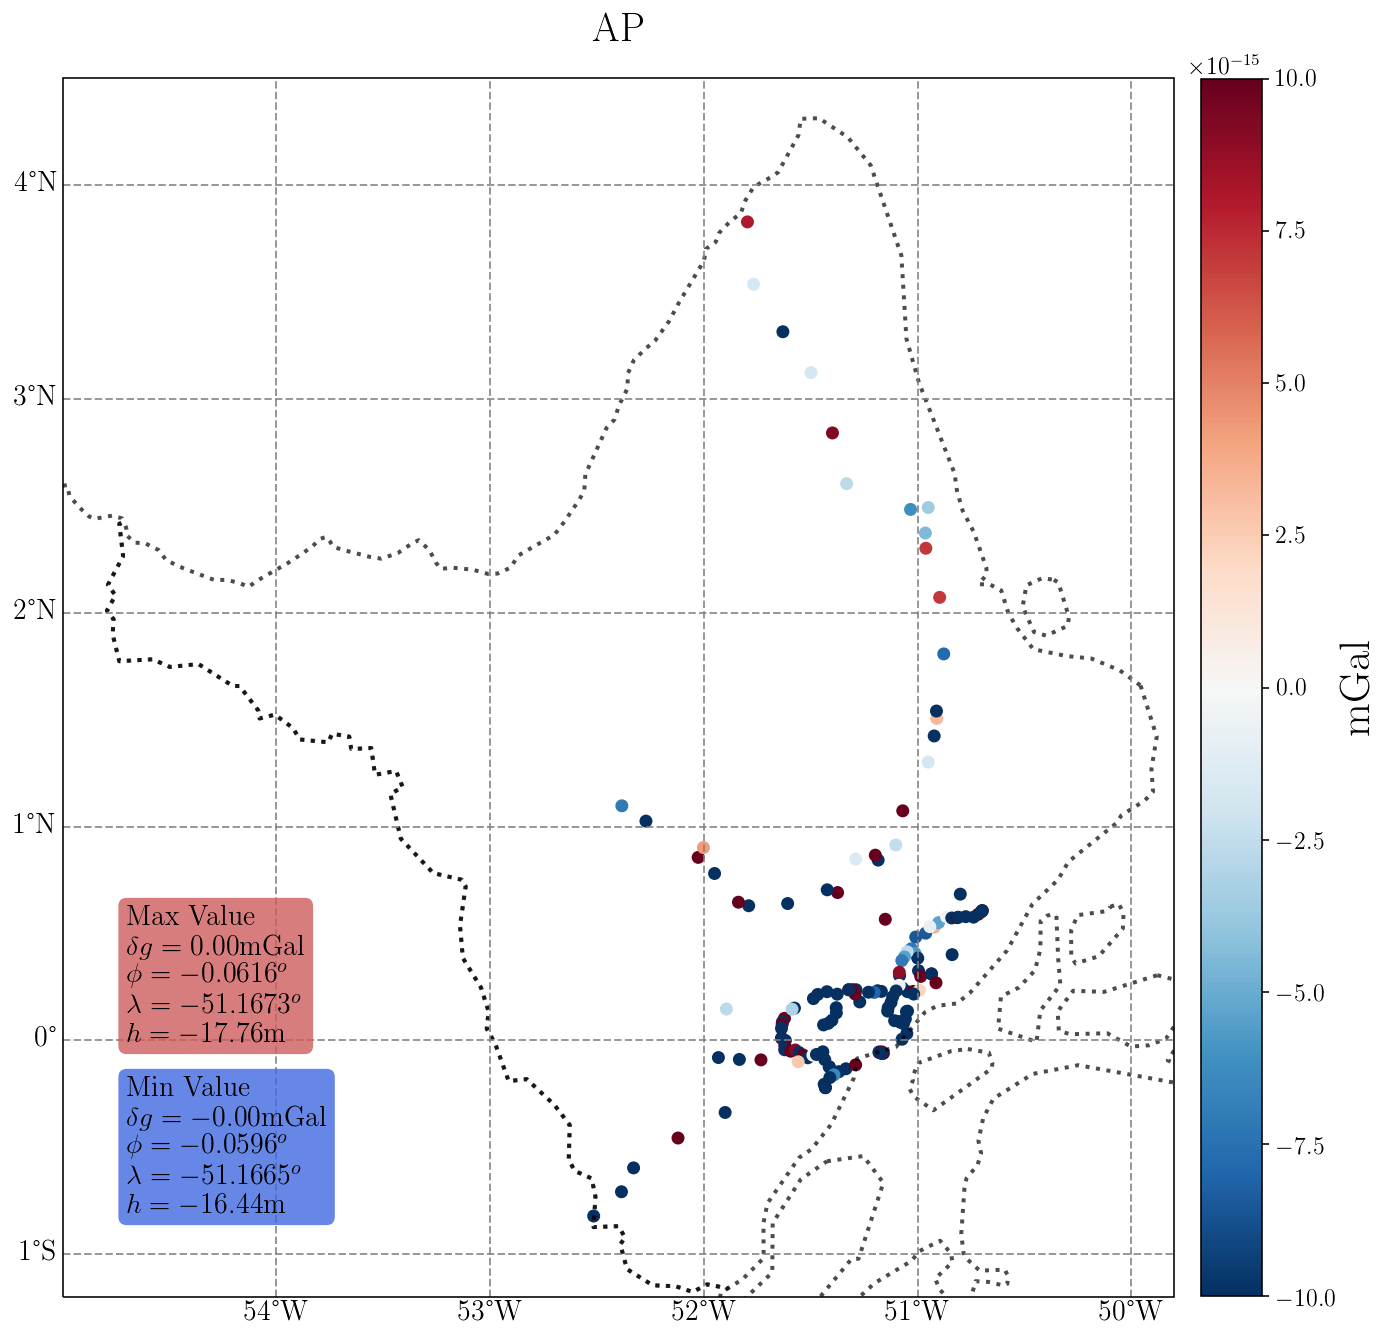

In [23]:
point_map(df.LONG, df.LAT, df.ALT, rc, uf, fig_size=(12.,14.), region=[-55,-49.8,-1.2,4.5], \
          sign=(-54.7,-54.7,0.,-0.8), shrink=0.8, lim_val=(True, 1e-13))

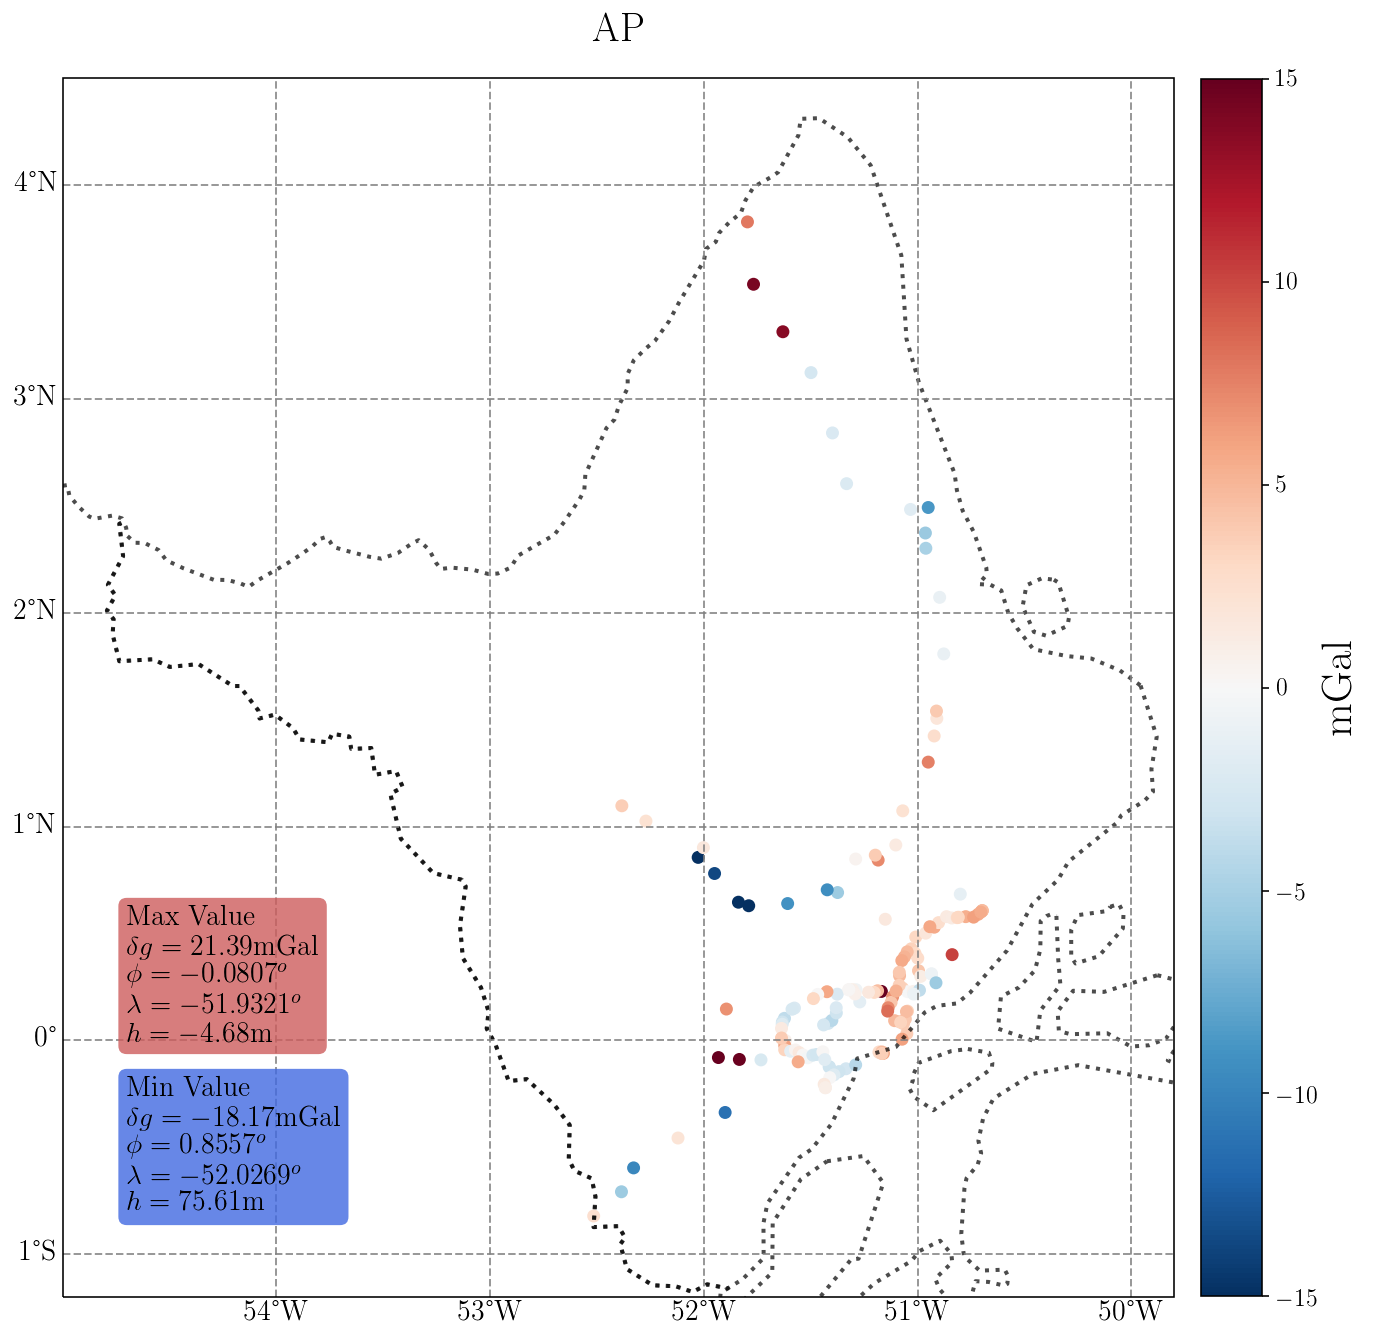

In [24]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-55,-49.8,-1.2,4.5], \
          sign=(-54.7,-54.7,0.,-0.8), shrink=0.8, lim_val=(True, 15.))

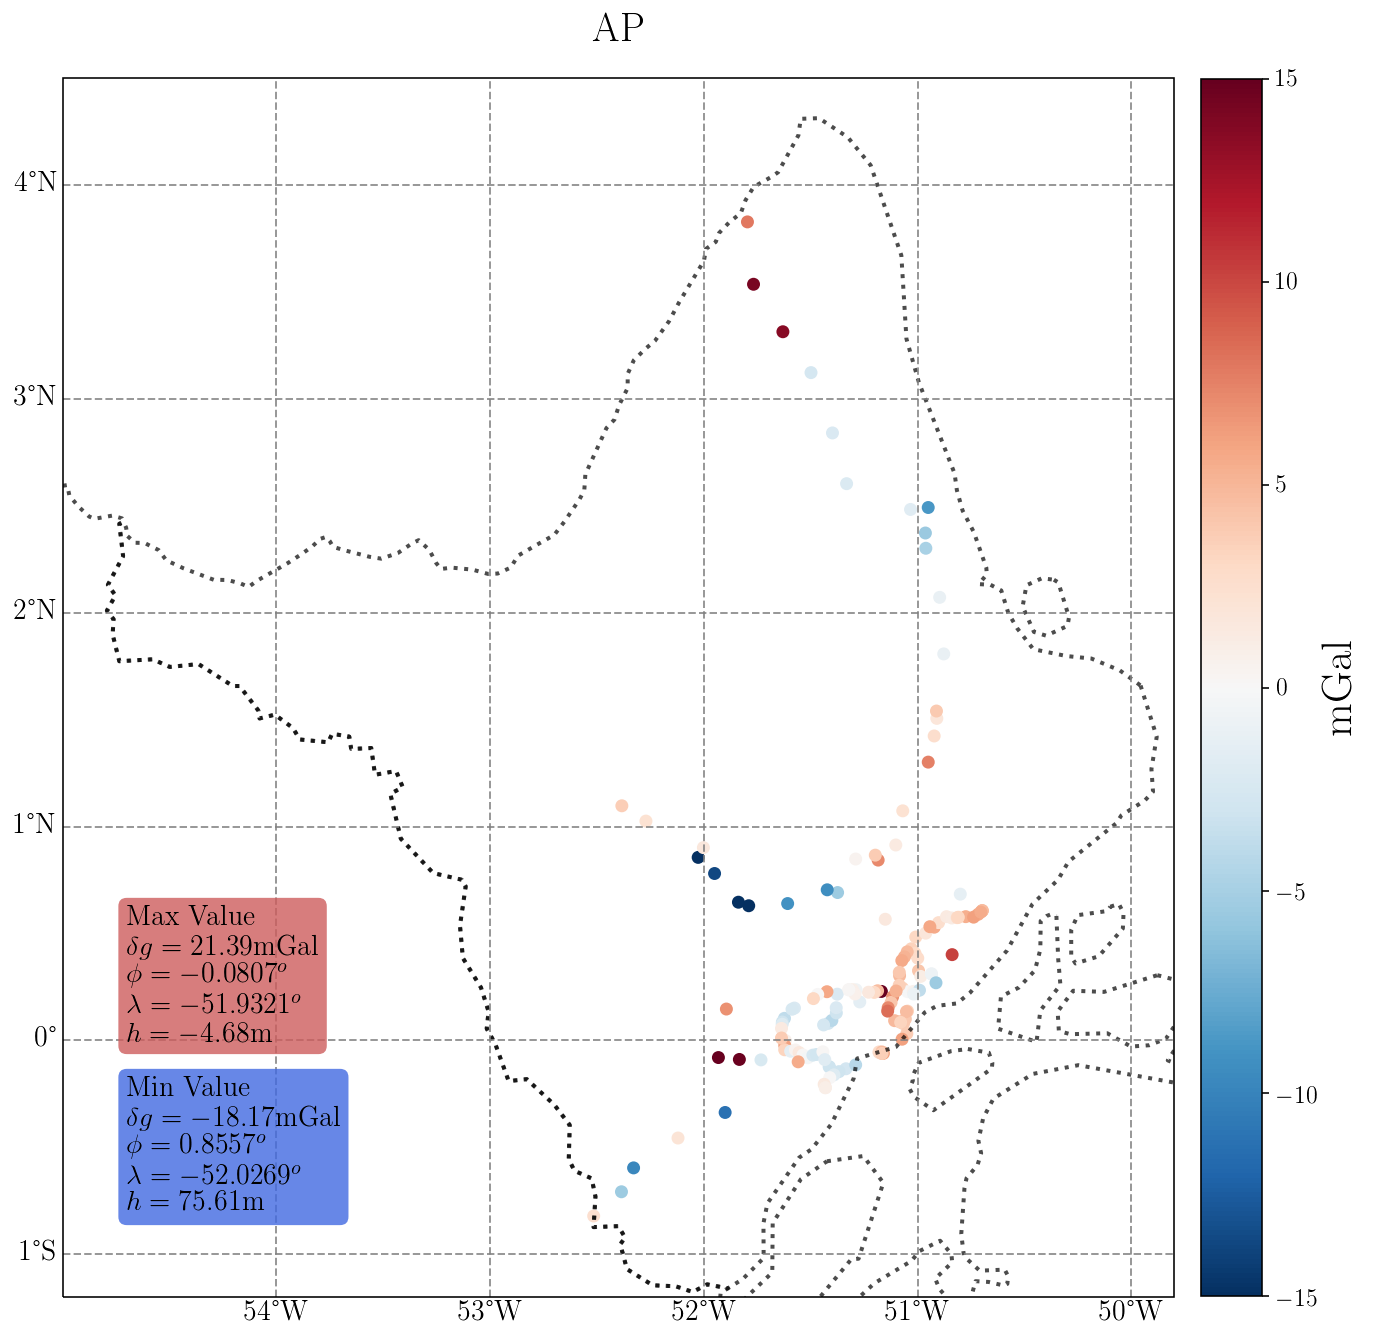

In [25]:
point_map(df.LONG, df.LAT, df.ALT, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), region=[-55,-49.8,-1.2,4.5], \
          sign=(-54.7,-54.7,0.,-0.8), shrink=0.8, lim_val=(True, 15.))

In [26]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [27]:
new_data = {'LONG':bdg.LONG.values, \
            'LAT':bdg.LAT.values, \
            'ALT':bdg.ALT_GEOM.values, \
            'BDG':bdg.GRAV.values, \
            'EIGEN':eigen.GRAV.values, \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-51.08530,0.087700,-7.730,978040.39,978036.665043,3.724957,9.269315e+11,-4.218847e-14
1,-51.06630,0.077900,-4.940,978042.06,978038.083888,3.976112,1.001249e+12,-1.558753e-13
2,-51.16970,0.228600,20.570,978040.94,978024.703537,16.236462,6.539159e+12,-4.618528e-14
3,-51.18740,0.231800,-0.990,978036.48,978031.793204,4.686796,-2.996758e+12,-3.641532e-14
4,-51.20330,0.224000,-10.690,978038.54,978035.551732,2.988268,9.834210e+11,-7.993606e-15
...,...,...,...,...,...,...,...,...
144,-50.94290,0.531464,-10.362,978036.66,978030.827720,5.832280,1.233018e+12,-8.881784e-16
145,-50.92278,1.423701,2.842,978006.11,978003.514815,2.595185,7.915197e+11,-1.110223e-14
146,-51.76787,3.536850,48.844,978025.53,978011.248036,14.281964,4.742401e+12,-1.776357e-15
147,-51.63048,3.314728,18.522,978032.32,978018.688119,13.631881,4.439463e+12,-1.598721e-14


In [28]:
print(df.RESID.min(), df.RESID.max())

-5.130464053593187e-09 8.315137911552029e-09


### Upward Continuation

In [29]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [30]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


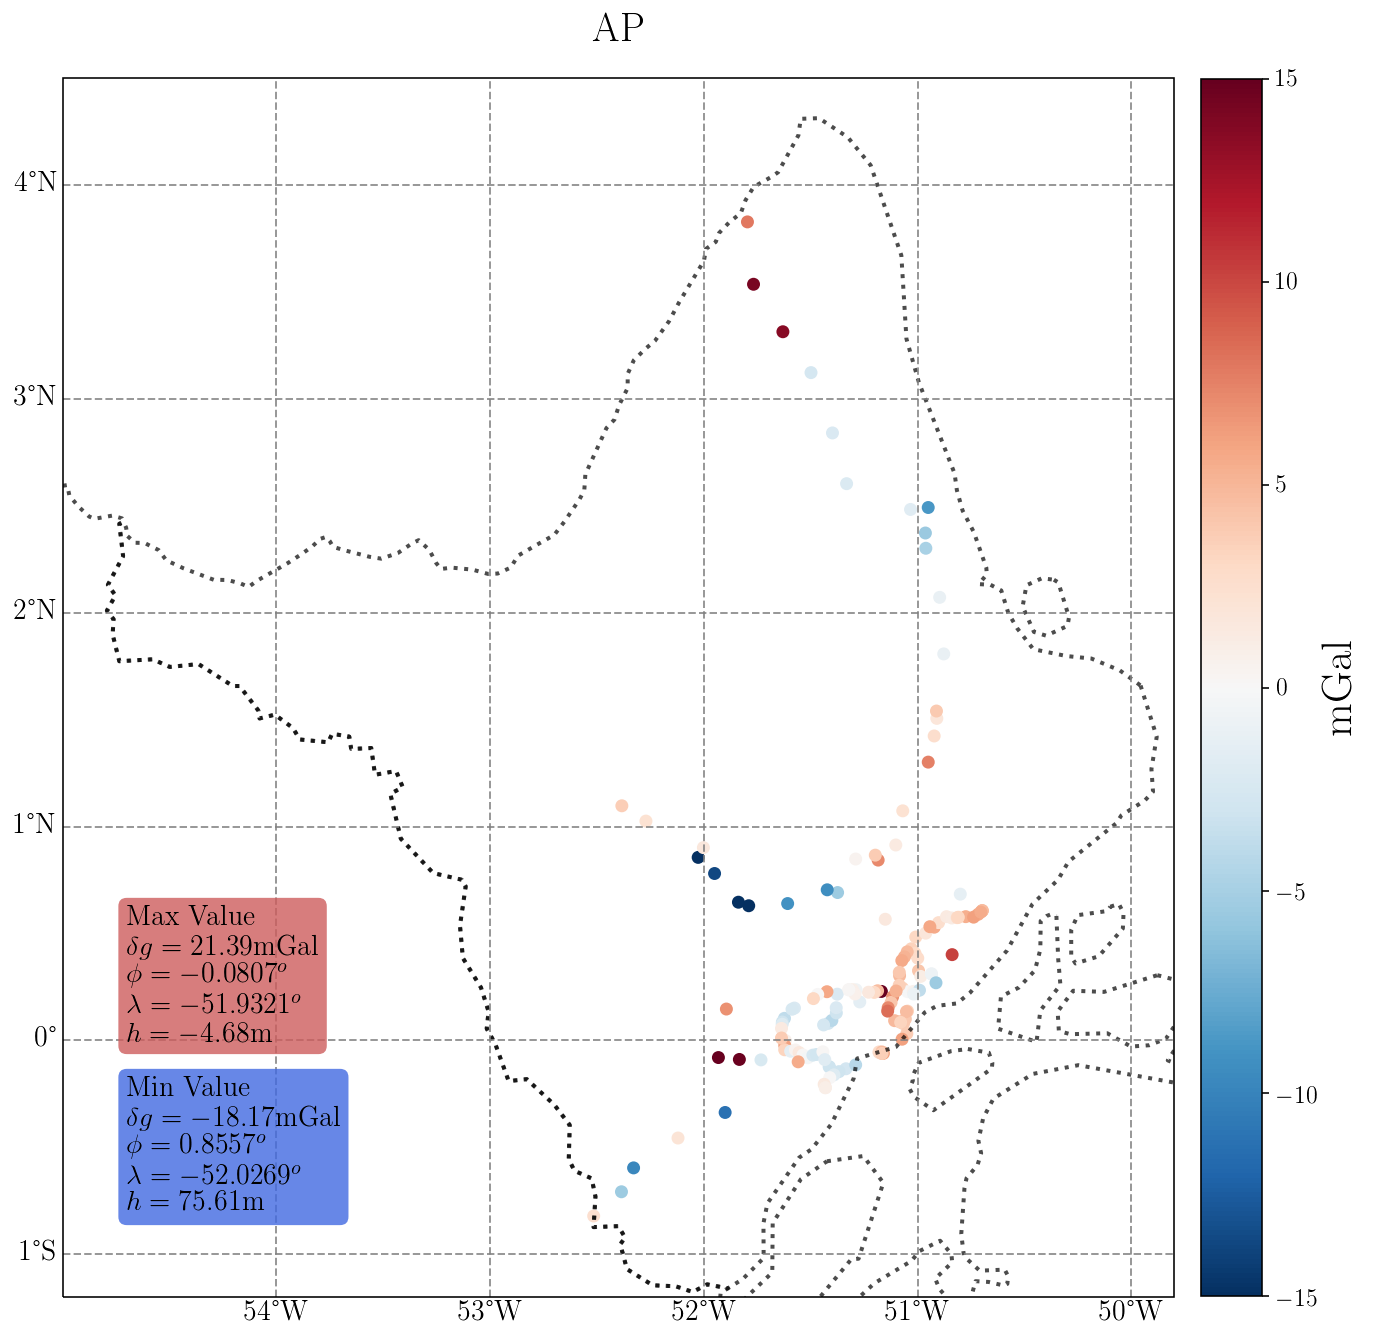

In [31]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-55,-49.8,-1.2,4.5], \
          sign=(-54.7,-54.7,0.,-0.8), shrink=0.8, lim_val=(True, 15.))

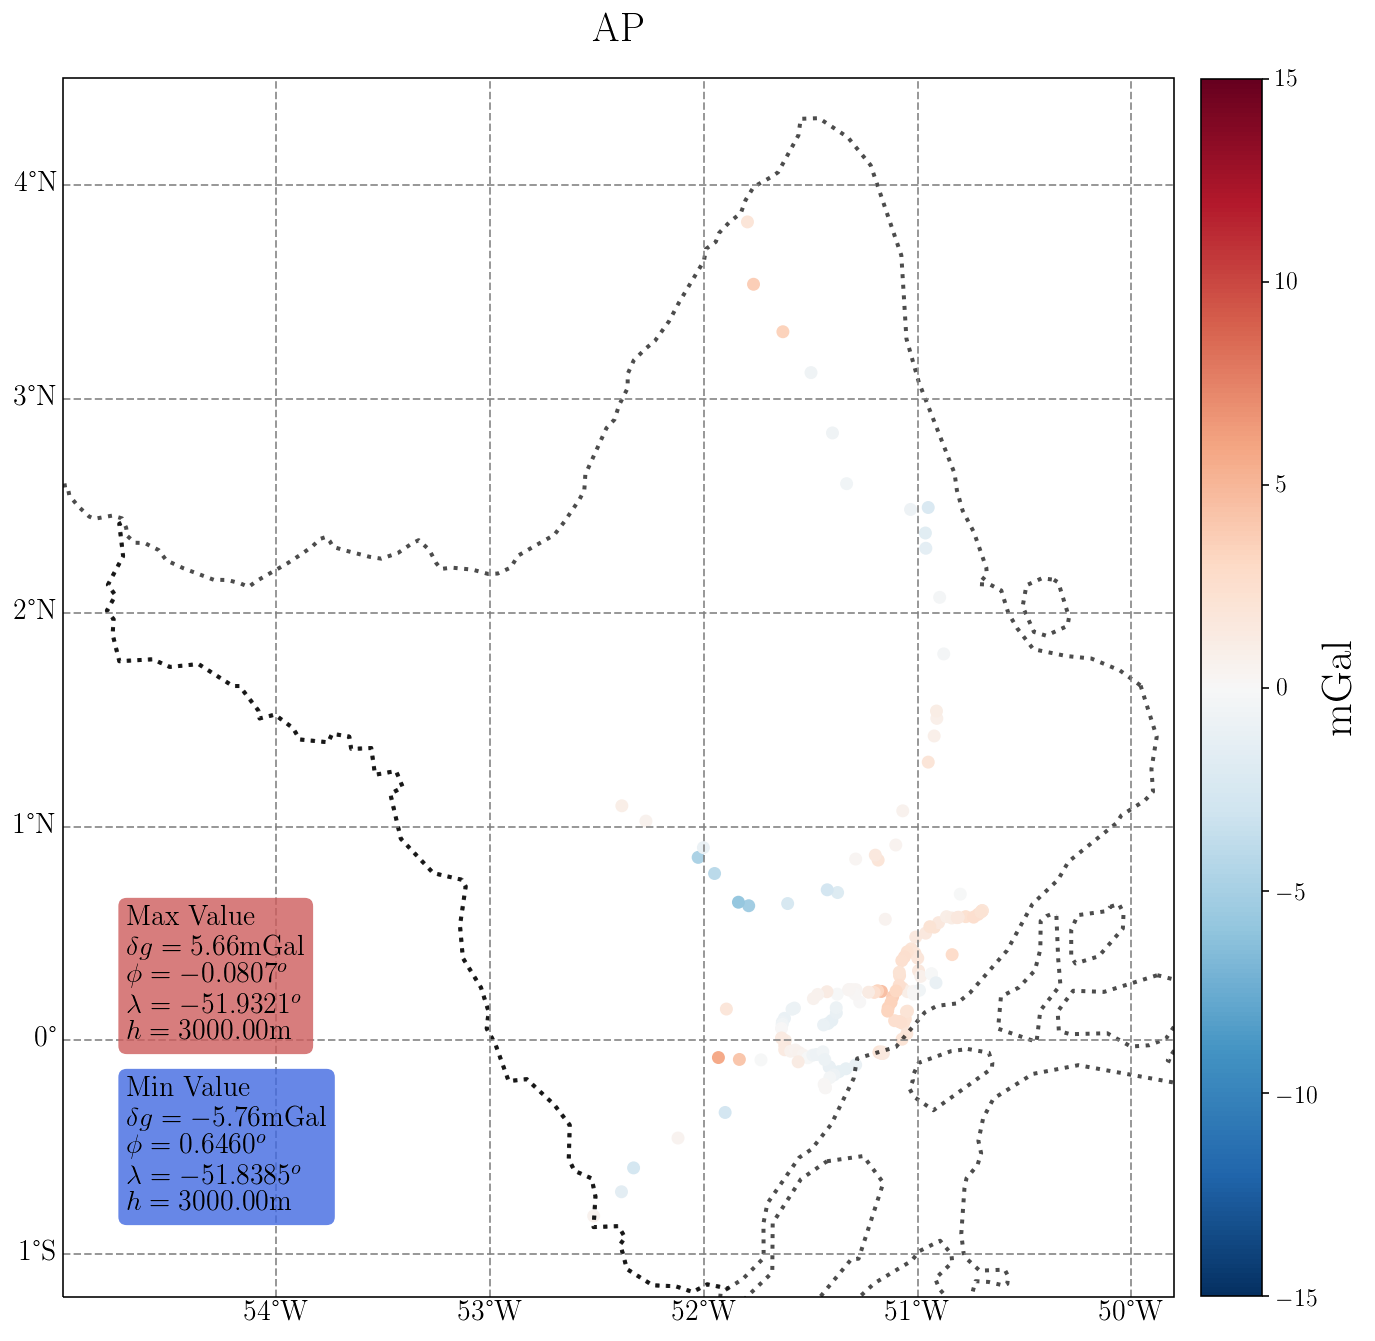

In [32]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(12.,14.), \
          region=[-55,-49.8,-1.2,4.5], sign=(-54.7,-54.7,0.,-0.8), shrink=0.8, lim_val=(True, 15.))

In [33]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


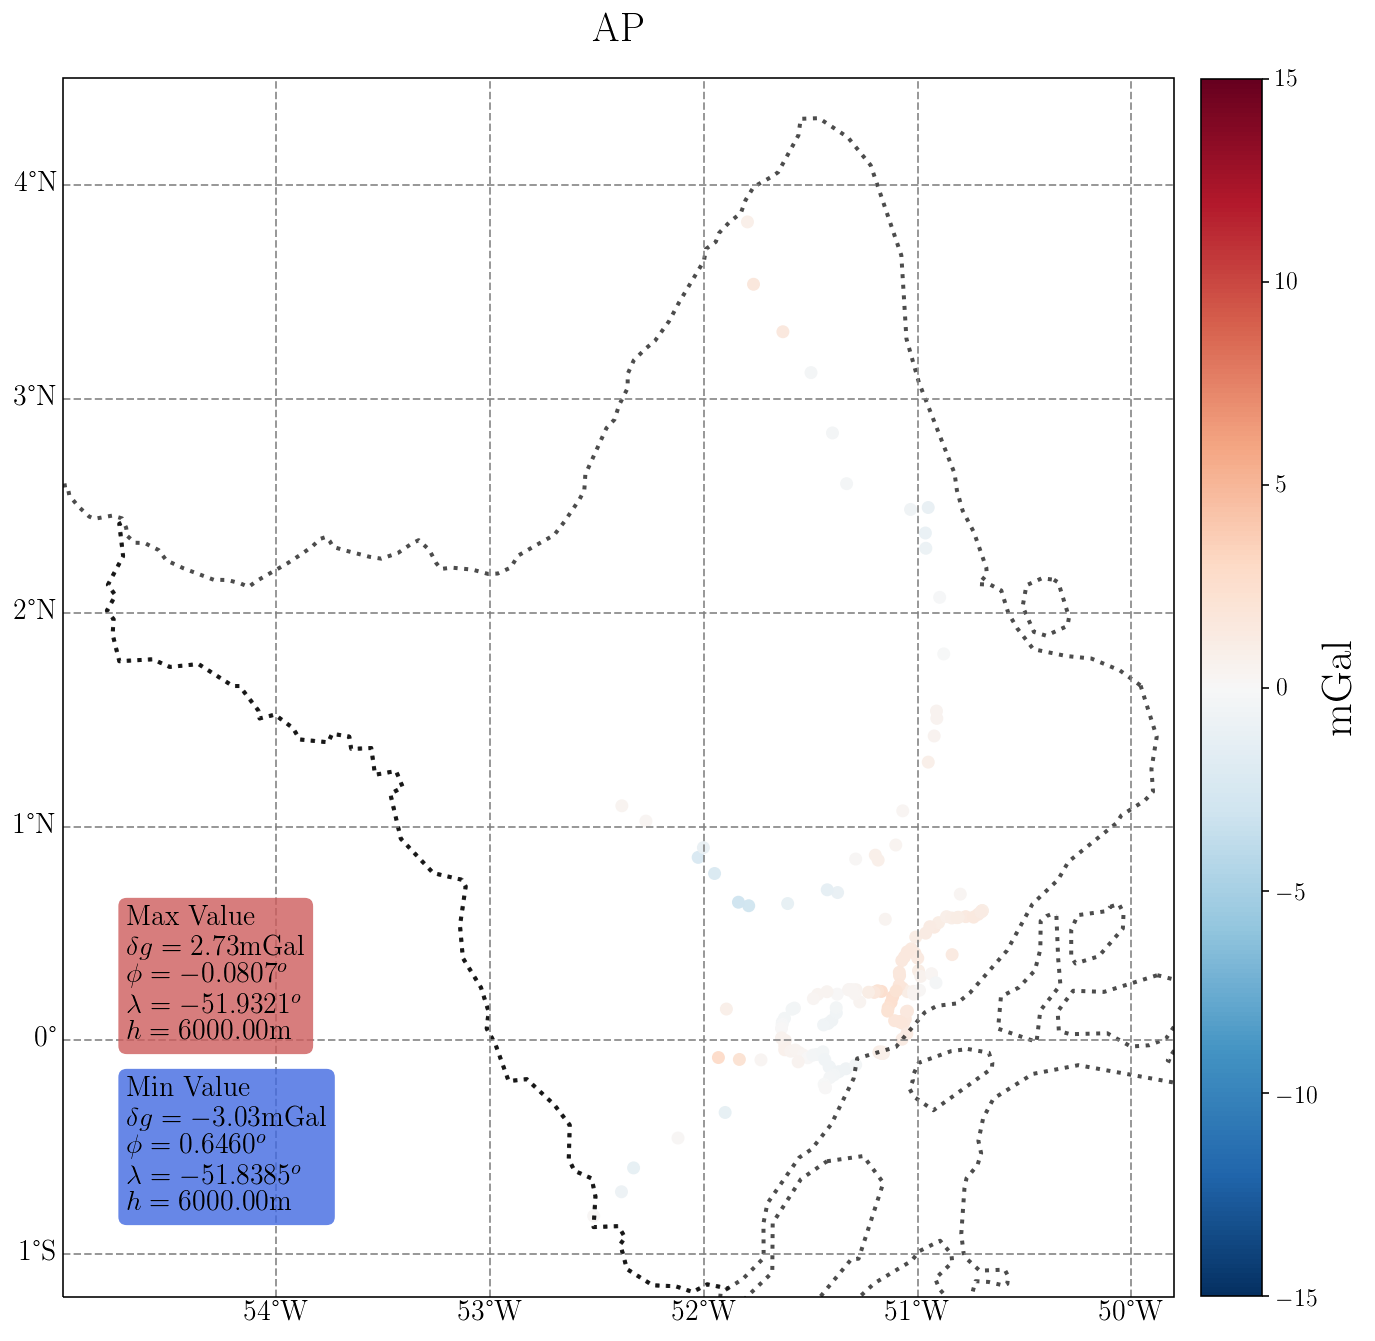

In [34]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(12.,14.), \
          region=[-55,-49.8,-1.2,4.5], sign=(-54.7,-54.7,0.,-0.8), shrink=0.8, lim_val=(True, 15.))

In [35]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


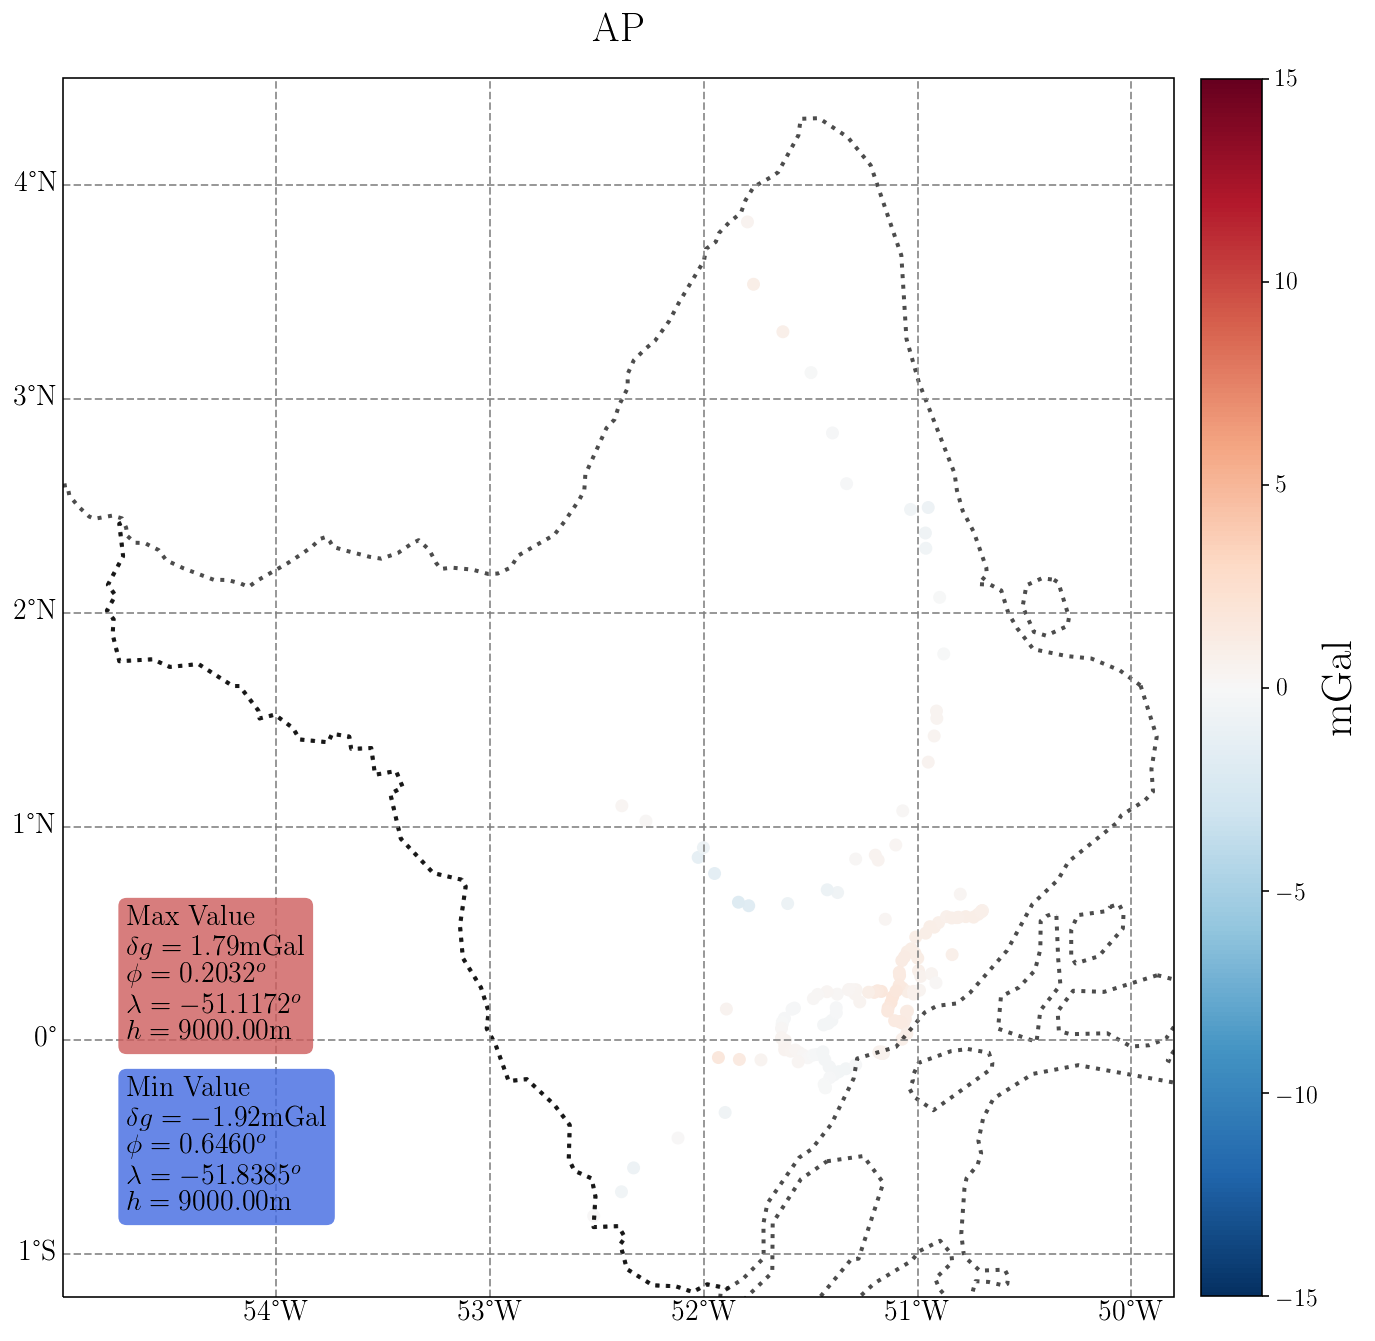

In [36]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(12.,14.), \
          region=[-55,-49.8,-1.2,4.5], sign=(-54.7,-54.7,0.,-0.8), shrink=0.8, lim_val=(True, 15.))

In [37]:
((85*8)*5)*4

13600